<a href="https://colab.research.google.com/github/milkywaypeko/ASD_ID_FI_Correlation/blob/main/ASD_ID_FI_Correlation_Google.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Import Library

In [1]:
import numpy as np # For Array, 
import pandas as pd # For Data
import matplotlib.pyplot as plt # For Graph
import seaborn as sns # For Pretty Graph
import statsmodels.api as sm # For LinearRegression
import statsmodels.formula.api as smf # For LinearRegression
from sklearn.preprocessing import PolynomialFeatures # For data power
from sklearn.model_selection import train_test_split # For resampling
from sklearn.linear_model import LinearRegression # For LinearRegression
from sklearn.metrics import mean_squared_error # For MSE
from sklearn.model_selection import LeaveOneOut # For LOOCV
from sklearn.model_selection import cross_val_score # For Cross Test
from sklearn.model_selection import KFold # For K-Fold
from sklearn.utils import resample # For resampling
from sklearn.metrics import mean_squared_error, explained_variance_score, r2_score #MSE, R2, ExVar error

## 2. Import Statistics

### 1) Define Region Name

In [2]:
regionDic = {'Seoul':'서울특별시', 'Busan' : '부산광역시', 'Daegu' : '대구광역시', 'Incheon' : '인천광역시', 'Gwangju' : '광주광역시', 'Daejeon' : '대전광역시', 'Ulsan' : '울산광역시', 'Sejong' : '세종특별자치시',
             'Gyeonggi-do' : '경기도', 'Gangwon-do' : '강원도', 'Chungcheongbuk-do' : '충청북도', 'Chungcheongnam-do' : '충청남도', 'Jeollabuk-do' : '전라북도', 'Jeollanam-do' : '전라남도',
             'Gyeongsangbuk-do' : '경상북도', 'Gyeongsangnam-do' : '경상남도', 'Jeju' : '제주특별자치도'}

### 2)Import CSV

#### (1) Disabled Population 

In [3]:
disabledPopulation = {}
for EnglishName, KoreanName in regionDic.items():
    disabledPopulation[EnglishName] = pd.read_csv('https://raw.githubusercontent.com/milkywaypeko/ASD_ID_FI_Correlation/main/Statistics/Disabled/Population%20of%20the%20disabled%20in%20{name}.csv'.format(name=EnglishName))
    #Label Disabled Population Statistics
    disabledPopulation[EnglishName].insert(0, '광역자치단체', KoreanName)

disabledPopulation['Gyeonggi-do'].drop('남/북',axis=1, inplace=True)

#### (2) Population Statistics

In [4]:
populationDic = {}
for EnglishName, KoreanName in regionDic.items():
    populationDic[EnglishName] = pd.read_csv('https://raw.githubusercontent.com/milkywaypeko/ASD_ID_FI_Correlation/main/Statistics/Population/Resident%20population%20of%20{name}.csv'.format(name=EnglishName))
    #Label Population Statistics
    populationDic[EnglishName].insert(0, '광역자치단체', KoreanName)

populationDic['Gyeonggi-do'].drop('남/북',axis=1, inplace=True)

#### (3) Financial independence Statistics

In [5]:
financial_Independence = {}
for EnglishName, KoreanName in regionDic.items():
    financial_Independence[EnglishName] = pd.read_csv('https://raw.githubusercontent.com/milkywaypeko/ASD_ID_FI_Correlation/main/Statistics/Finance/Financial%20Independence%20of%20{name}.csv'.format(name=EnglishName))
    #Label Population Statistics
    financial_Independence[EnglishName].insert(0, '광역자치단체', KoreanName)

financial_Independence['Gyeonggi-do'].drop('시/군',axis=1, inplace=True)

### 3) Connect And Merge Statistics

In [6]:
#Connect Disabled Population Statistics
dataD = pd.concat(disabledPopulation, ignore_index=True)
#Connect Population Statistics
dataP = pd.concat(populationDic, ignore_index=True)
#Connect Finance Statistics
dataF = pd.concat(financial_Independence, ignore_index=True)

In [7]:
#Merge All Statistics
temp = pd.merge(dataD, dataP)
data = pd.merge(temp, dataF)

### 4) rearrange data

In [8]:
#Make Statistics For Developmental Disability
data['발달장애'] = data['지적장애'] + data['자폐성']

#Make Rate of Intellectual disability
data['지적장애_비율'] = data['지적장애'] / data['인구']

#Make Rate of Autistic Spectrum Disorder
data['자폐성_비율'] = data['자폐성'] / data['인구']

#Make Rate of Developmental Disability
data['발달장애_비율'] = data['발달장애'] / data['인구']

#Make Rate of Developmental Disability of Autistic Spectrum Disorder
data['발달_자폐성_비율'] = data['자폐성'] / data['발달장애']

#For label in english
data.rename(columns = {'광역자치단체' : 'RLG', '기초자치단체' : 'BLG', '지적장애' : 'ID', '자폐성' : 'ASD', '인구' : 'Population',  '재정자립도 (%)' : 'Financial_Independence', '재정자주도 (%)' : 'Financial_often', '발달장애' : 'DD', '지적장애_비율' : 'ID_rate', '자폐성_비율':'ASD_rate', '발달장애_비율' : 'DD_rate', '발달_자폐성_비율':'DD_ASD_rate'}, inplace = True)

#Column arrange
data = data[['RLG', 'BLG', 'ID', 'ASD', 'DD', 'Population', 'ID_rate', 'ASD_rate', 'DD_rate', 'DD_ASD_rate', 'Financial_Independence', 'Financial_often']]

data

,RLG,BLG,ID,ASD,DD,Population,ID_rate,ASD_rate,DD_rate,DD_ASD_rate,Financial_Independence,Financial_often
0,서울특별시,종로구,396,111,507,161869,0.002446,0.000686,0.003132,0.218935,47.408302,63.576182
1,서울특별시,중구,304,67,371,136488,0.002227,0.000491,0.002718,0.180593,54.928717,61.137462
2,서울특별시,용산구,530,106,636,245185,0.002162,0.000432,0.002594,0.166667,39.182358,55.529962
3,서울특별시,성동구,710,174,884,308979,0.002298,0.000563,0.002861,0.196833,32.502263,54.757351
4,서울특별시,광진구,818,167,985,366972,0.002229,0.000455,0.002684,0.169543,26.716462,51.975160
...,...,...,...,...,...,...,...,...,...,...,...,...
222,경상남도,산청군,322,19,341,35430,0.009088,0.000536,0.009625,0.055718,8.900000,58.900000
223,경상남도,함양군,250,16,266,39506,0.006328,0.000405,0.006733,0.060150,10.000000,59.300000
224,경상남도,거창군,382,26,408,62005,0.006161,0.000419,0.006580,0.063725,8.900000,58.600000
225,경상남도,합천군,382,14,396,44582,0.008568,0.000314,0.008883,0.035354,8.800000,64.000000


## 3. Correlation between ASD and Financial Independence

In [9]:
#Linear regression (X=Financial_Independence Y=ASD_rate) with statsmodels.formula.api of statsmodels
ASD_rate_ols_smf = smf.ols(formula='ASD_rate ~ Financial_Independence', data=data)

ASD_rate_ols_smf_results = ASD_rate_ols_smf.fit()
ASD_rate_ols_smf_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ASD_rate   R-squared:                       0.142
Model:                            OLS   Adj. R-squared:                  0.138
Method:                 Least Squares   F-statistic:                     37.09
Date:                Sun, 23 Apr 2023   Prob (F-statistic):           4.83e-09
Time:                        06:03:09   Log-Likelihood:                 1682.4
No. Observations:                 227   AIC:                            -3361.
Df Residuals:                     225   BIC:                            -3354.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0.0004   1.95e-05     19.406      0.000       0.000       0.000
Financial_Independence  4.873e-06      8e-07      6.090      0.000     3.3e-06    6.45e-06
==============================================================================
Omnibus:                       10.682   Durbin-Watson:                   1.342
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               11.519
Skew:                           0.437   Prob(JB):                      0.00315
Kurtosis:                       3.673   Cond. No.                         48.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

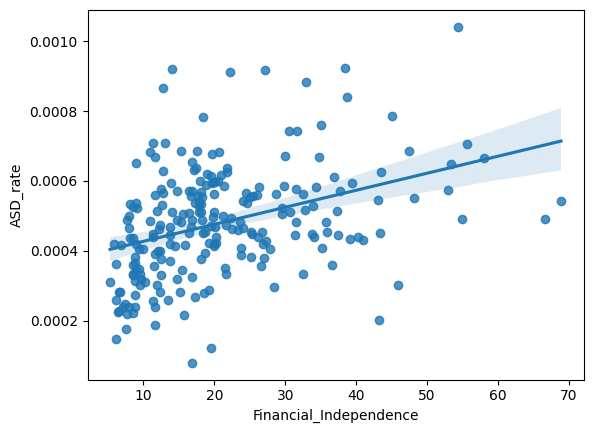

In [10]:
#Draw a graph (X=Financial_Independence Y=ASD_rate) with seaborn
sns.regplot(x='Financial_Independence', y='ASD_rate', data=data)
plt.show()

# For Additional data analysis (For Computer Science)

---

## 1. Linear regression with sklearn

### 1) Linear regression (X=Financial_Independence Y=ASD_rate) with sklearn

In [11]:
ols_ASD_rate_skl = LinearRegression(fit_intercept=True)

ASD_rate_skl_X_train = data['Financial_Independence'].values.reshape(-1, 1)
ASD_rate_skl_y_true = data['ASD_rate']

ols_ASD_rate_skl.fit(ASD_rate_skl_X_train, ASD_rate_skl_y_true)
print('Intercept : ', ols_ASD_rate_skl.intercept_, 'Coef : ', ols_ASD_rate_skl.coef_)
ols_ASD_rate_skl_pre = ols_ASD_rate_skl.predict(data['Financial_Independence'].values.reshape(-1, 1))

ols_ASD_rate_skl_summary = { 'R2' : r2_score(ASD_rate_skl_y_true, ols_ASD_rate_skl_pre),
                  'Ex. Var' : explained_variance_score(ASD_rate_skl_y_true, ols_ASD_rate_skl_pre),
                  'MSE' : mean_squared_error(ASD_rate_skl_y_true, ols_ASD_rate_skl_pre)}

for k, v in ols_ASD_rate_skl_summary.items():
    print(k,':', v)

Intercept :  0.00037832802857155494 Coef :  [4.87333138e-06]
R2 : 0.1415222123800275
Ex. Var : 0.14152221238002738
MSE : 2.1384062195390713e-08


### 2) Draw a graph (X=Financial_Independence Y=ASD_rate) with matplotlib

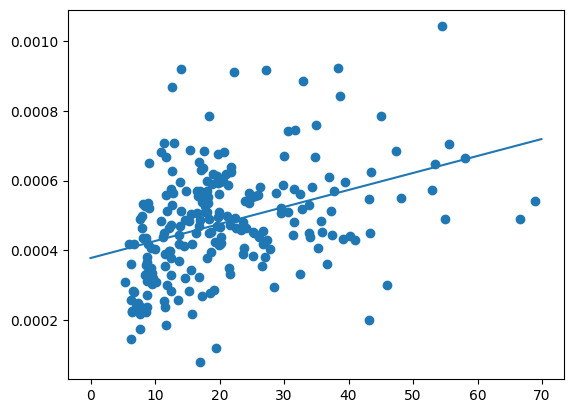

In [12]:
ols_ASD_rate_skl_x = np.arange(0, 70, 0.1)
ols_ASD_rate_skl_y = [ols_ASD_rate_skl.coef_*x + ols_ASD_rate_skl.intercept_ for x in ols_ASD_rate_skl_x]
plt.scatter(data['Financial_Independence'], data['ASD_rate'])
plt.plot(ols_ASD_rate_skl_x, ols_ASD_rate_skl_y)
plt.show()

## 2. Linear regression with statsmodels

### 1) Linear regression (X=Financial_Independence Y=ASD_rate) with statsmodels..api of statsmodels

In [13]:
ASD_rate_sm_X_train = data['Financial_Independence']
ASD_rate_sm_y_true = data['ASD_rate']

ASD_rate_ols_sm = sm.OLS(ASD_rate_sm_y_true, sm.add_constant(ASD_rate_sm_X_train))

ASD_rate_ols_sm_results = ASD_rate_ols_sm.fit()
ASD_rate_ols_sm_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ASD_rate   R-squared:                       0.142
Model:                            OLS   Adj. R-squared:                  0.138
Method:                 Least Squares   F-statistic:                     37.09
Date:                Sun, 23 Apr 2023   Prob (F-statistic):           4.83e-09
Time:                        06:03:10   Log-Likelihood:                 1682.4
No. Observations:                 227   AIC:                            -3361.
Df Residuals:                     225   BIC:                            -3354.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0004   1.95e-05     19.406      0.000       0.000       0.000
Financial_Independence  4.873e-06      8e-07      6.090      0.000     3.3e-06    6.45e-06
==============================================================================
Omnibus:                       10.682   Durbin-Watson:                   1.342
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               11.519
Skew:                           0.437   Prob(JB):                      0.00315
Kurtosis:                       3.673   Cond. No.                         48.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 2)Draw a graph (X=Financial_Independence Y=ASD_rate) with matplotlib

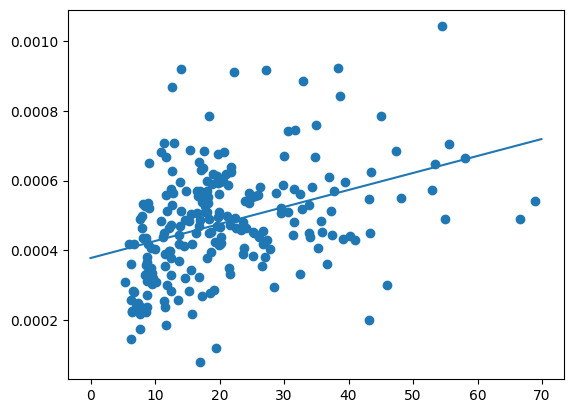

In [14]:
FI_OLS_x = np.arange(0, 70, 0.1)
FI_OLS_y = [ASD_rate_ols_sm_results.predict([1, x]) for x in FI_OLS_x]
plt.scatter(data['Financial_Independence'], data['ASD_rate'])
plt.plot(FI_OLS_x, FI_OLS_y)
plt.show()

## 3. Preprocessing For MSE resampling test

In [15]:
# Make Polynomial Maximum 5
Financial_Independence_pol = PolynomialFeatures(degree=5, interaction_only=False, include_bias=False) 

# polf[0] power 1, polf[1] power 2, polf[2] power 3, polf[3] power 4, polf[4] power 5
Financial_Independence_polf = Financial_Independence_pol.fit_transform(data.loc[:, 'Financial_Independence'].values.reshape(-1, 1))

### 1) Resampling 50% degree 1 to 5

In [16]:
#For Resampling
X, y = Financial_Independence_polf, data.ASD_rate 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=10)

# ols model with intercept and Power
lm1 = LinearRegression(fit_intercept=True)
lm2 = LinearRegression(fit_intercept=True)
lm3 = LinearRegression(fit_intercept=True)
lm4 = LinearRegression(fit_intercept=True)
lm5 = LinearRegression(fit_intercept=True)

# Fitting
lm1_fit = lm1.fit(X_train[ : ,0].reshape(-1, 1), y_train)
lm2_fit = lm2.fit(X_train[ : ,0 : 2], y_train)
lm3_fit = lm3.fit(X_train[ : ,0 : 3], y_train)
lm4_fit = lm4.fit(X_train[ : ,0 : 4], y_train)
lm5_fit = lm5.fit(X_train, y_train)

# Predict
lm1_predict = lm1_fit.predict(X_test[ : ,0].reshape(-1, 1))
lm2_predict = lm2_fit.predict(X_test[ : ,0 : 2])
lm3_predict = lm3_fit.predict(X_test[ : ,0 : 3])
lm4_predict = lm4_fit.predict(X_test[ : ,0 : 4])
lm5_predict = lm5_fit.predict(X_test)

# Make MSE'
print('lm1 MSE : ', mean_squared_error(y_test, lm1_predict))
print('lm2 MSE : ', mean_squared_error(y_test, lm2_predict))
print('lm3 MSE : ', mean_squared_error(y_test, lm3_predict))
print('lm4 MSE : ', mean_squared_error(y_test, lm4_predict))
print('lm5 MSE : ', mean_squared_error(y_test, lm5_predict))

lm1 MSE :  2.472140177156666e-08
lm2 MSE :  2.403820230455493e-08
lm3 MSE :  2.3665596505195317e-08
lm4 MSE :  2.307415959093198e-08
lm5 MSE :  2.326225443017782e-08


#### (1) Draw a graph (X=Power Y=MSE) with seaborn

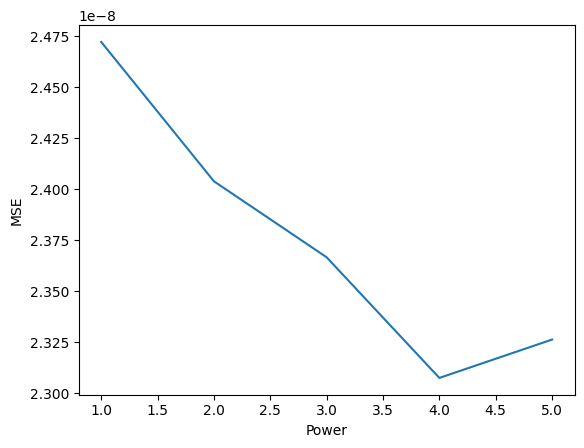

In [17]:
MSE_X = np.array([1, 2, 3, 4, 5])
MSE_y = [mean_squared_error(y_test, lm1_predict),
         mean_squared_error(y_test, lm2_predict),
         mean_squared_error(y_test, lm3_predict),
         mean_squared_error(y_test, lm4_predict),
         mean_squared_error(y_test, lm5_predict)]
sns.lineplot(x = MSE_X, y = MSE_y) 
plt.xlabel('Power')
plt.ylabel('MSE')
plt.show()

### 2) For LOOCV splits data

In [18]:
X, y = Financial_Independence_polf, data.ASD_rate 

loocv = LeaveOneOut()
loocv.get_n_splits(X)

227

In [19]:
#For LOOCV Make MSE
lm = [LinearRegression(fit_intercept=True)] * 5
lm_fit = [LinearRegression(fit_intercept=True)] * 5
lm_predict = [np.ndarray] * 5
loocvMSE = []
for i in np.arange(0, 5):
    loocv_mse = []
    
    for train_index, test_index in loocv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        if(i==0):
            lm_fit[0] = lm[0].fit(X_train[ : ,0].reshape(-1, 1), y_train)
            lm_predict[0] = lm_fit[0].predict(X_test[ : ,0].reshape(-1, 1))
        else:
            lm_fit[i] = lm[i].fit(X_train[ : ,0 : i+1], y_train)
            lm_predict[i] = lm_fit[i].predict(X_test[ : ,0 : i+1])
        
        loocv_mse.append(mean_squared_error(y_test, lm_predict[i]))
    loocvMSE.append(np.array(loocv_mse).mean())
    print('lm[', str(i + 1), '] MSE : ', loocvMSE[i])

lm[ 1 ] MSE :  2.1827010580636272e-08
lm[ 2 ] MSE :  2.1184676851991945e-08
lm[ 3 ] MSE :  2.126619024659133e-08
lm[ 4 ] MSE :  2.0587522333111203e-08
lm[ 5 ] MSE :  2.0810022374247614e-08


#### (1) Draw a graph (X=Power Y=MSE) with seaborn

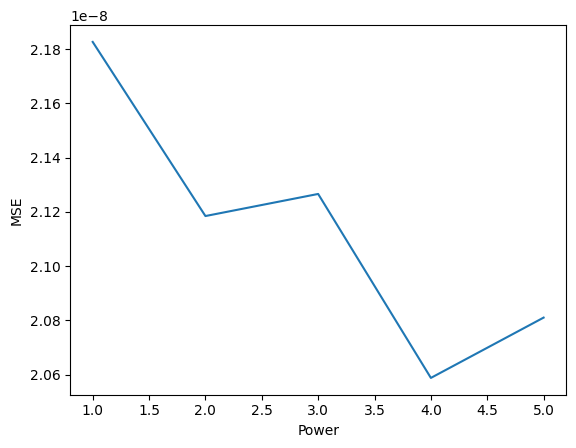

In [20]:
MSE_LOOCV_X = np.array([1, 2, 3, 4, 5])
MSE_LOOCV_y = np.array(loocvMSE)
sns.lineplot(x = MSE_LOOCV_X, y = MSE_LOOCV_y) 
plt.xlabel('Power')
plt.ylabel('MSE')
plt.show()

### 3) For Cross Test LOOCV splits data

In [21]:
# For Cross Test LOOCV
lm = [LinearRegression(fit_intercept=True)]*5
scoreMSE = []

for i in np.arange(0, 5):
    if(i==0):
        cval = cross_val_score(lm[i],
                                    Financial_Independence_polf[:, 0].reshape(-1, 1),
                                    data.ASD_rate ,
                                    cv=len(data), # k=n k-Fold -> LOOCV
                                    n_jobs=-1,
                                    scoring='neg_mean_squared_error')
        scoreMSE.append(-cval.mean())
        
    else:
        cval = cross_val_score(lm[i],
                                    Financial_Independence_polf[:, 0 : i+1],
                                    data.ASD_rate ,
                                    cv=len(data), # k=n k-Fold -> LOOCV
                                    n_jobs=-1,
                                    scoring='neg_mean_squared_error')
        scoreMSE.append(-cval.mean())
    print('lm[', str(i + 1), '] MSE : ', scoreMSE[i])

lm[ 1 ] MSE :  2.1827010580636272e-08
lm[ 2 ] MSE :  2.1184676851991945e-08
lm[ 3 ] MSE :  2.126619024659133e-08
lm[ 4 ] MSE :  2.0587522333111203e-08
lm[ 5 ] MSE :  2.0810022374247614e-08


#### (1) Draw a graph (X=Power Y=MSE) with seaborn

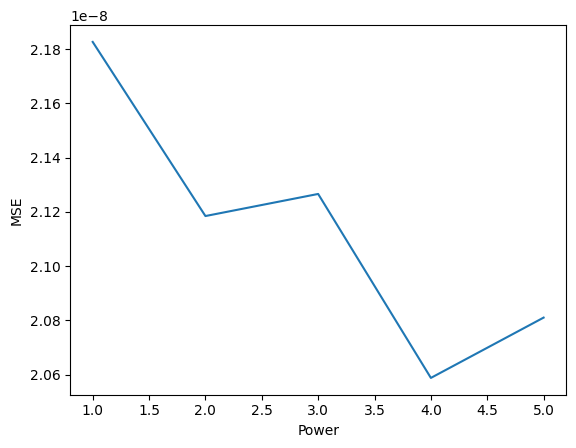

In [22]:
MSE_score_X = np.array([1, 2, 3, 4, 5])
MSE_score_y = np.array(scoreMSE)
sns.lineplot(x = MSE_score_X, y = MSE_score_y) 
plt.xlabel('Power')
plt.ylabel('MSE')
plt.show()

### 4)For K-Fold Make MSE

In [23]:
#Load K-Fold Model
X, y = Financial_Independence_polf, data.ASD_rate 
kf = KFold(n_splits=10, shuffle=True, random_state=10)

lm1_MSE :  2.2004386628875764e-08
lm2_MSE :  2.124999211328784e-08
lm3_MSE :  2.1283436722240926e-08
lm4_MSE :  2.0755558603111968e-08
lm5_MSE :  2.0928434761912505e-08


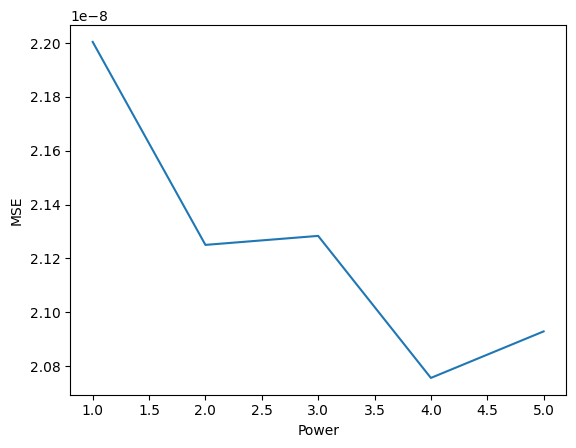

In [24]:
#For K-Fold Make MSE
kf_poly = []

for i in range(0, 5):
    kf_mse = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        if i == 0:
            X_TRAIN = X_train[:, 0:1]
            X_TEST = X_test[:,0:1]
            
        else:
            X_TRAIN = X_train[:, 0:i+1]
            X_TEST = X_test[:,0:i+1]
        kf_mse.append(
            mean_squared_error(
                y_test,
                LinearRegression(fit_intercept=True)
                                 .fit(
                                     X_TRAIN,
                                     y_train
                                 )
                                 .predict(
                                     X_TEST
                                 )
                            )
                        )
    kf_poly.append(np.array(kf_mse).mean())
    print('lm' + str(i + 1) + '_MSE : ', kf_poly[i])

MSE_KFold_X = np.array([1, 2, 3, 4, 5])
MSE_KFold_y = np.array(kf_poly)
MSE_KFold_y
sns.lineplot(x = MSE_KFold_X, y = MSE_KFold_y) 
plt.xlabel('Power')
plt.ylabel('MSE')
plt.show()

### 5)Linear regression (X=Financial_Independence^4 Y=ASD_rate) with statsmodels..api of statsmodels

In [25]:
ASD_rate_4_X_train = Financial_Independence_polf[ : ,0 : 4]
ASD_rate_4_y_true = data['ASD_rate']

ASD_rate_4_ols_sm = sm.OLS(ASD_rate_4_y_true, sm.add_constant(ASD_rate_4_X_train))

ASD_rate_4_ols_sm_results = ASD_rate_4_ols_sm.fit()
ASD_rate_4_ols_sm_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ASD_rate   R-squared:                       0.209
Model:                            OLS   Adj. R-squared:                  0.195
Method:                 Least Squares   F-statistic:                     14.67
Date:                Sun, 23 Apr 2023   Prob (F-statistic):           1.20e-10
Time:                        06:03:29   Log-Likelihood:                 1691.7
No. Observations:                 227   AIC:                            -3373.
Df Residuals:                     222   BIC:                            -3356.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -1.8e-05      0.000     -0.175      0.861      -0.000       0.000
x1          6.886e-05   1.78e-05      3.858      0.000    3.37e-05       0.000
x2          -3.21e-06   9.98e-07     -3.217      0.001   -5.18e-06   -1.24e-06
x3          6.328e-08   2.17e-08      2.922      0.004    2.06e-08    1.06e-07
x4         -4.297e-10   1.57e-10     -2.731      0.007    -7.4e-10    -1.2e-10
==============================================================================
Omnibus:                       13.284   Durbin-Watson:                   1.392
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               17.531
Skew:                           0.423   Prob(JB):                     0.000156
Kurtosis:                       4.067   Cond. No.                     2.97e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.97e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### (1) Draw a graph (X=Financial_Independence^4 Y=ASD_rate) with seaborn

<Axes: xlabel='Financial_Independence', ylabel='ASD_rate'>

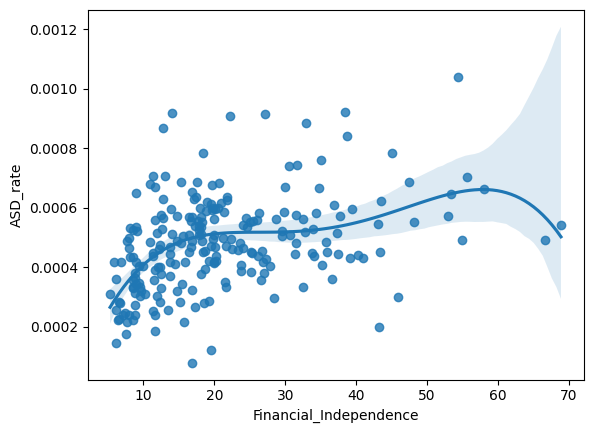

In [26]:
sns.regplot(x='Financial_Independence', y='ASD_rate', data=data, order = 4)

#### (2) Draw a graph (X=Financial_Independence^2 Y=ASD_rate) with matplotlib

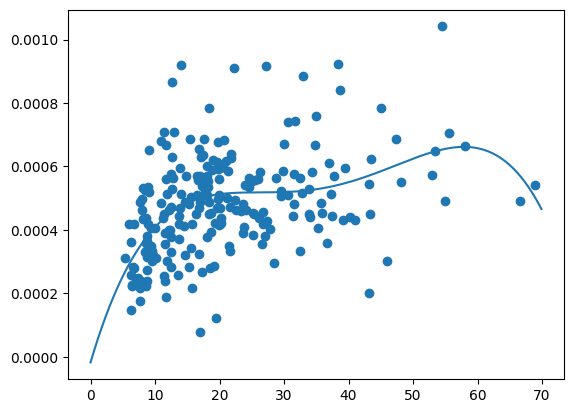

In [27]:
FI_OLS_4_x = np.arange(0, 70, 0.1)
FI_OLS_4_y = [ASD_rate_4_ols_sm_results.predict([1, x, np.power(x, 2), np.power(x, 3), np.power(x, 4)]) for x in FI_OLS_4_x]
plt.scatter(data['Financial_Independence'], data['ASD_rate'])
plt.plot(FI_OLS_4_x, FI_OLS_4_y)
plt.show()

##### This model Lower MSE but hard to interprint

### 6)Linear regression (X=Financial_Independence Y=ASD_rate) power with statsmodels..api of statsmodels

In [28]:
for i in range(0, 5):
    ASD_rate_for_X_train = Financial_Independence_polf[ : , 0: i + 1]
    ASD_rate_for_y_true = data['ASD_rate']

    ASD_rate_for_ols_sm = sm.OLS(ASD_rate_for_y_true, sm.add_constant(ASD_rate_for_X_train))

    ASD_rate_for_ols_sm_results = ASD_rate_for_ols_sm.fit()
    print(ASD_rate_for_ols_sm_results.summary())

                            OLS Regression Results                            
Dep. Variable:               ASD_rate   R-squared:                       0.142
Model:                            OLS   Adj. R-squared:                  0.138
Method:                 Least Squares   F-statistic:                     37.09
Date:                Sun, 23 Apr 2023   Prob (F-statistic):           4.83e-09
Time:                        06:03:32   Log-Likelihood:                 1682.4
No. Observations:                 227   AIC:                            -3361.
Df Residuals:                     225   BIC:                            -3354.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004   1.95e-05     19.406      0.0

<Axes: xlabel='Financial_Independence', ylabel='ASD_rate'>

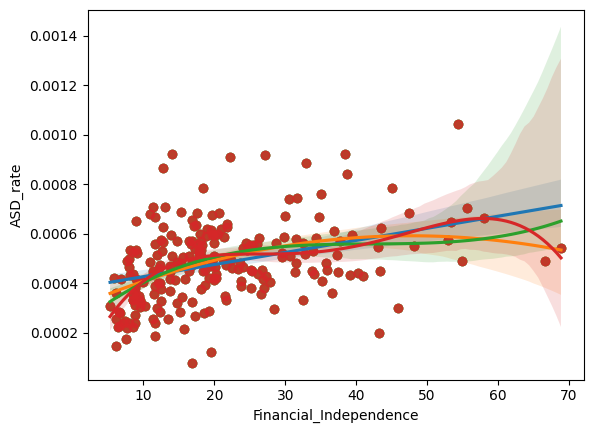

In [29]:
#Draw a graph power with seaborn
sns.regplot(x='Financial_Independence', y='ASD_rate', data=data, order = 1)
sns.regplot(x='Financial_Independence', y='ASD_rate', data=data, order = 2)
sns.regplot(x='Financial_Independence', y='ASD_rate', data=data, order = 3)
sns.regplot(x='Financial_Independence', y='ASD_rate', data=data, order = 4)

<Axes: xlabel='Financial_Independence', ylabel='ASD_rate'>

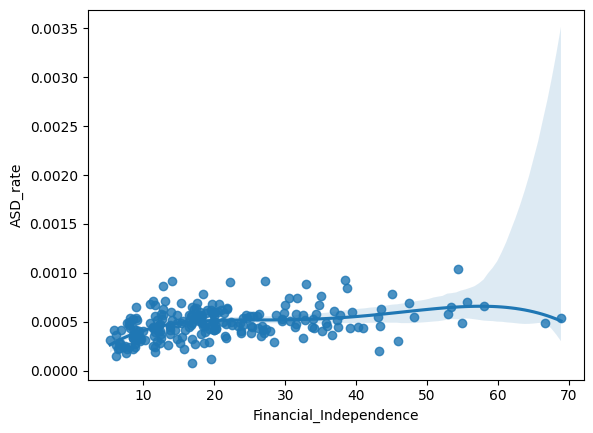

In [30]:
#Draw a graph power 5 with seaborn
sns.regplot(x='Financial_Independence', y='ASD_rate', data=data, order = 5)

In [31]:
# More flexibility get Low MSE but meaningless and difficult to interpret
# And correlation is maintained despite the high flexibility.
# Increasing flexibility lowers the P-value.

## 4. BoostStrap

In [32]:
def boot_fn(data, start_index, end_index, X_val, y_val):
    m = LinearRegression(fit_intercept=True).fit(
        data[X_val].iloc[start_index:end_index].values.reshape(-1, 1),
        data[y_val].iloc[start_index:end_index]
    )
    
    return m.intercept_, m.coef_

boot_fn(data, 0, len(data), 'Financial_Independence', 'ASD_rate')

(0.00037832802857155494, array([4.87333138e-06]))

In [33]:
boot_fn(resample(data, replace=True, n_samples=len(data)), 0, len(data), 'Financial_Independence', 'ASD_rate')

(0.00037367863658150724, array([5.45802394e-06]))

t1 bs estimate & se 0.0003787753230118681 1.9703540483571558e-05
t2 bs estimate & se 4.907663308367553e-06 9.039232171208852e-07


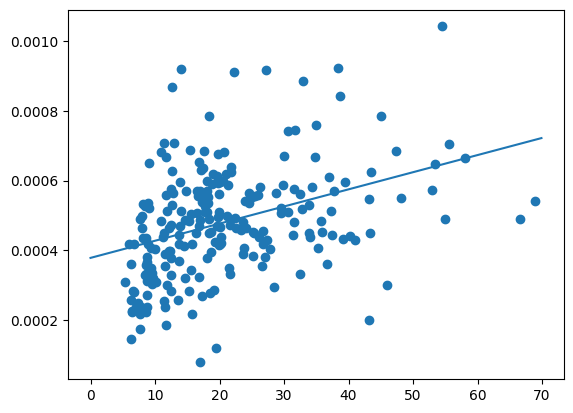

In [34]:
bs_boot = {'t1' : [], 't2':[]}

for i in range(0, 1000):
    bs_boot['t1'].append(
        boot_fn(resample(data, replace=True, n_samples=len(data)), 0, len(data), 'Financial_Independence', 'ASD_rate')[0]
    )
    bs_boot['t2'].append(
        boot_fn(resample(data, replace=True, n_samples=len(data)), 0, len(data), 'Financial_Independence', 'ASD_rate')[1][0]
    )
    
t1_es = np.array(bs_boot['t1']).mean()
t1_se = np.array(bs_boot['t1']).std()
t2_es = np.array(bs_boot['t2']).mean()
t2_se = np.array(bs_boot['t2']).std()

print('t1 bs estimate & se', t1_es, t1_se)
print('t2 bs estimate & se', t2_es, t2_se)

#Draw a graph (X=Financial_Independence(boot) Y=ASD_rate) with matplotlib
def predicBoot_function(x):
    return (t2_es*x + t1_es)
FI_Boot_x = np.arange(0, 70, 0.1)
FI_Boot_y = [predicBoot_function(x) for x in FI_Boot_x]
plt.scatter(data['Financial_Independence'], data['ASD_rate'])
plt.plot(FI_Boot_x, FI_Boot_y)
plt.show()

# For Additional Infomation

---

## 1. Drow for find Additional Correlation

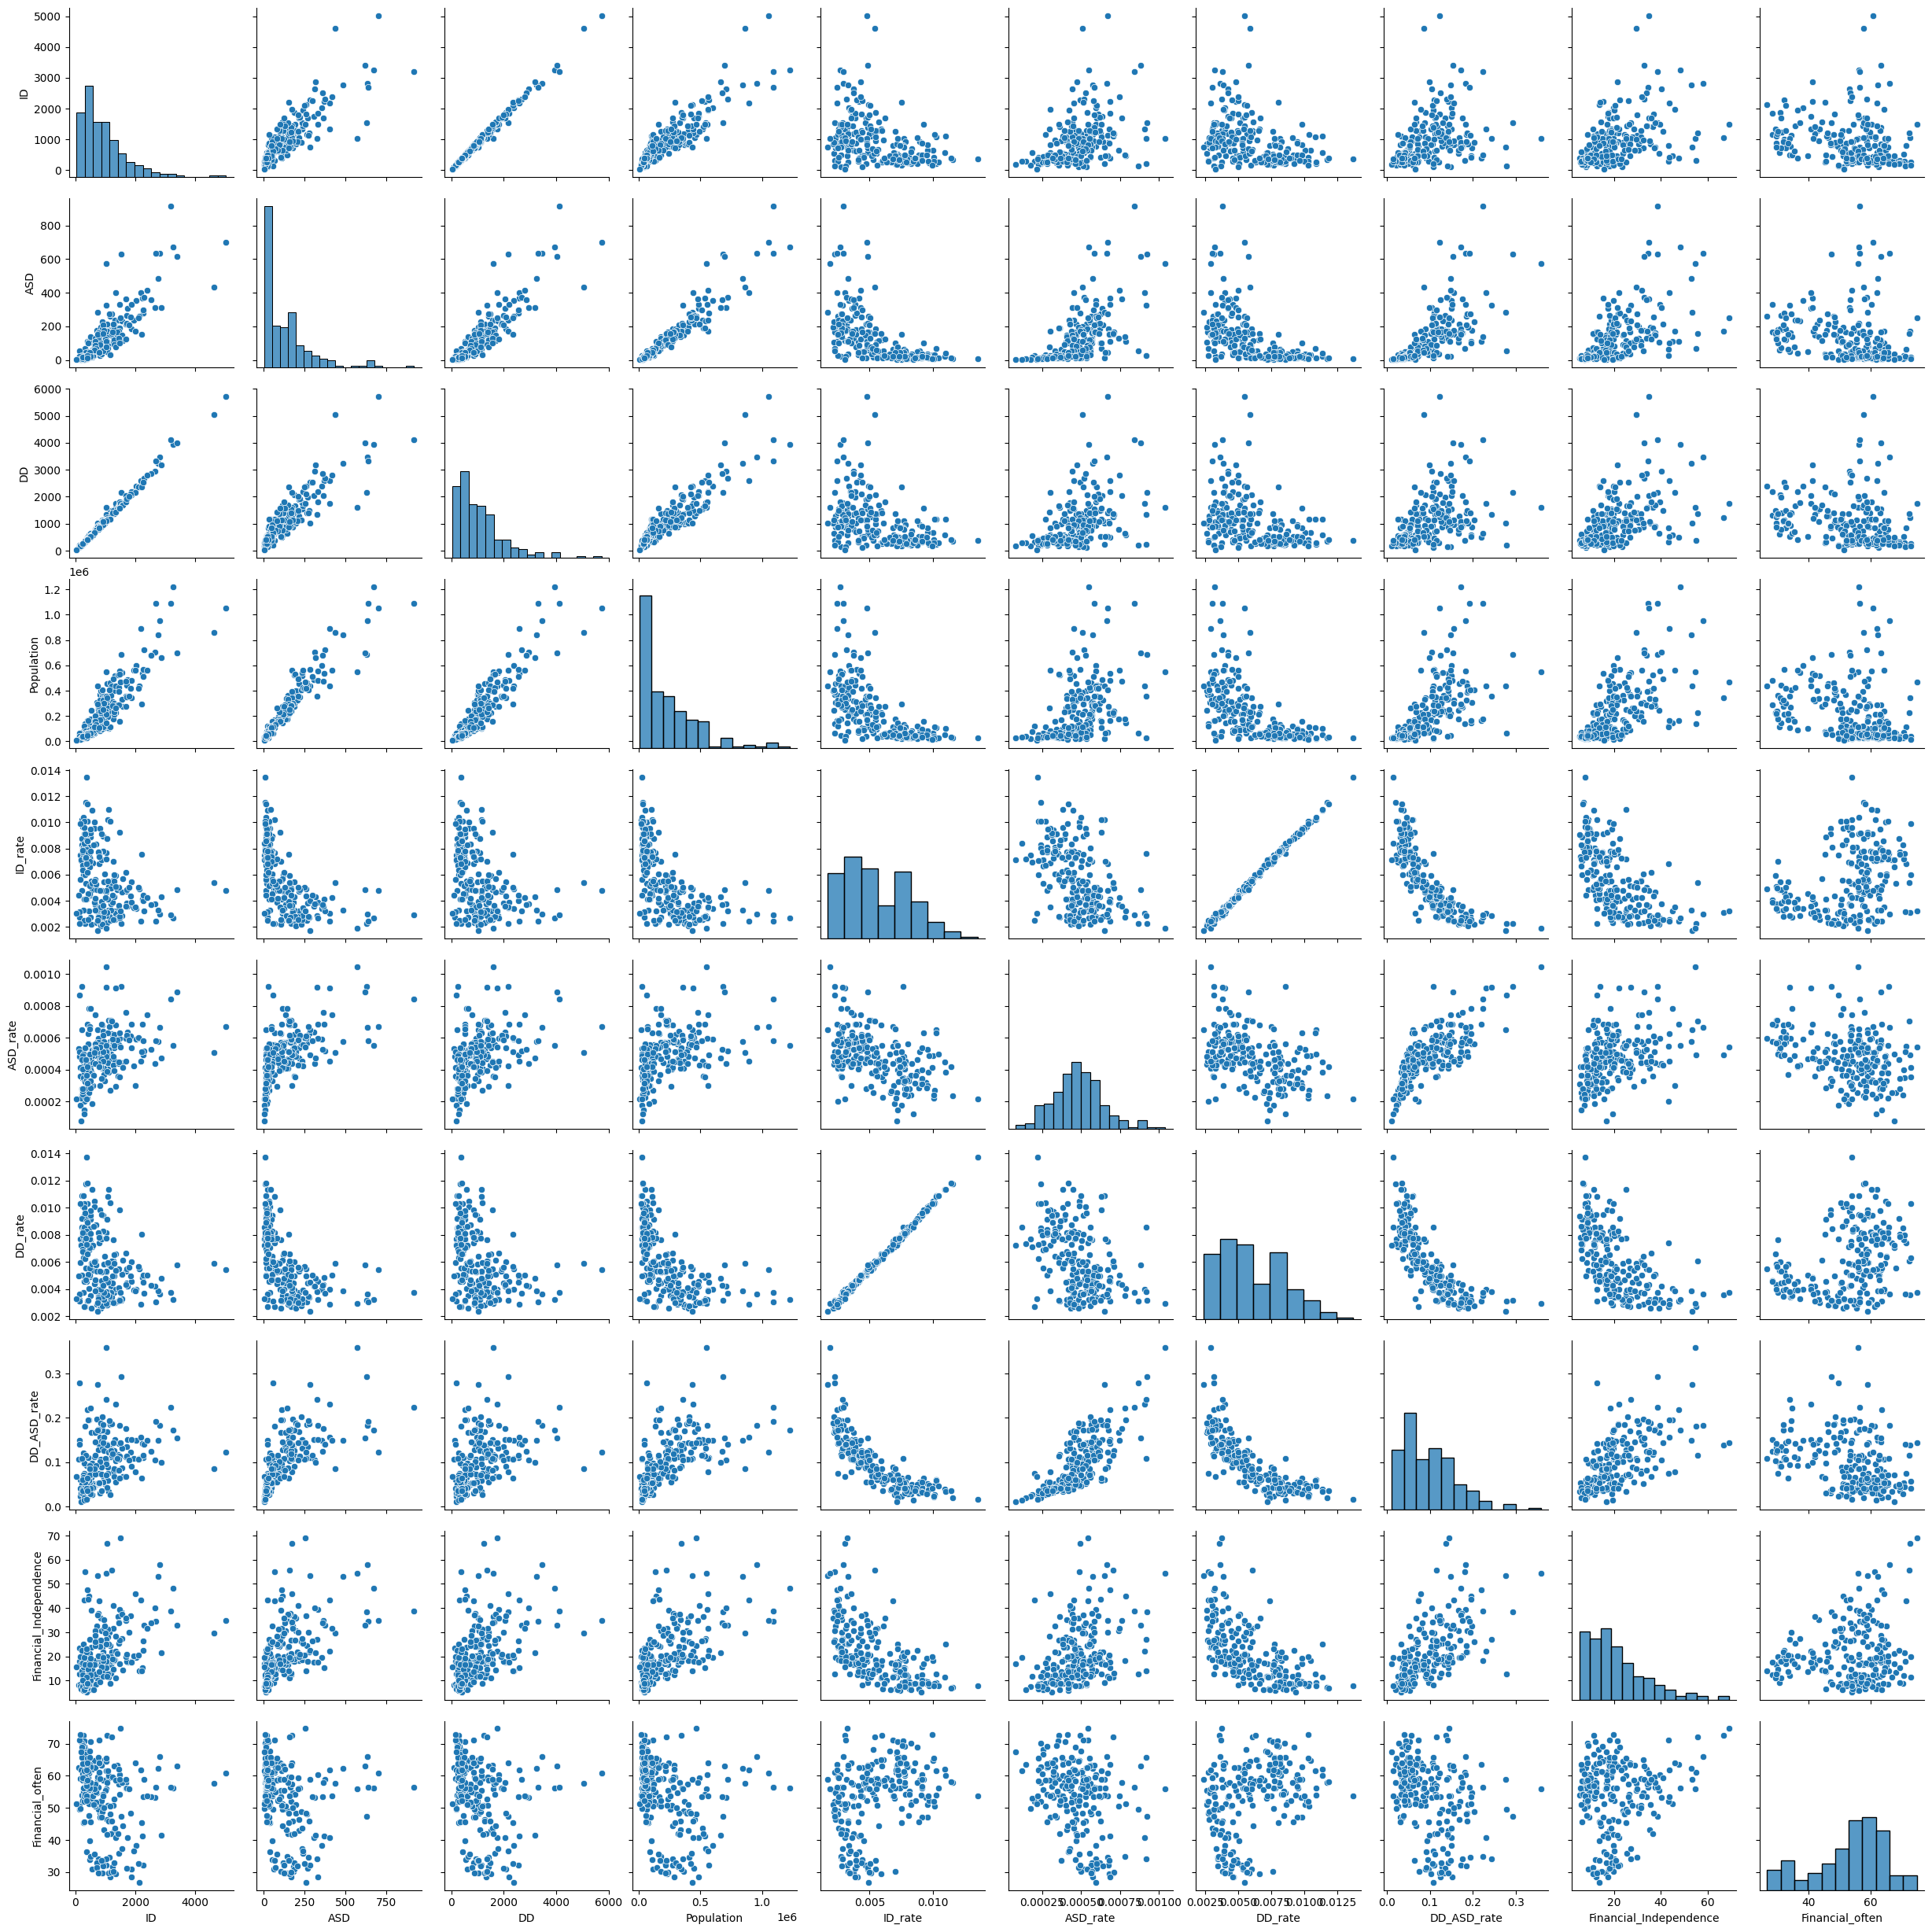

In [35]:
sns.pairplot(data)
plt.show()

## 2. Linear regression (X=Financial_Independence Y=ID_rate) with statsmodels.formula.api of statsmodels

In [36]:
ID_rate_ols_smf = smf.ols(formula='ID_rate ~ Financial_Independence', data=data)

ID_rate_ols_smf_results = ID_rate_ols_smf.fit()
ID_rate_ols_smf_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                ID_rate   R-squared:                       0.373
Model:                            OLS   Adj. R-squared:                  0.370
Method:                 Least Squares   F-statistic:                     133.8
Date:                Sun, 23 Apr 2023   Prob (F-statistic):           1.35e-24
Time:                        06:04:17   Log-Likelihood:                 1092.3
No. Observations:                 227   AIC:                            -2181.
Df Residuals:                     225   BIC:                            -2174.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0.0082      0.000     31.273      0.000       0.008       0.009
Financial_Independence    -0.0001   1.08e-05    -11.569      0.000      -0.000      -0.000
==============================================================================
Omnibus:                        6.805   Durbin-Watson:                   0.988
Prob(Omnibus):                  0.033   Jarque-Bera (JB):                6.962
Skew:                           0.406   Prob(JB):                       0.0308
Kurtosis:                       2.723   Cond. No.                         48.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

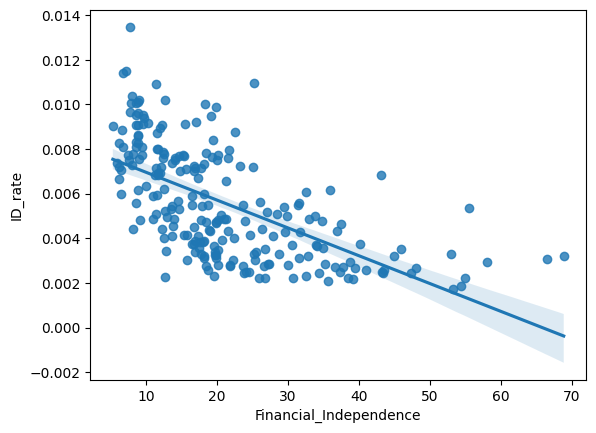

In [37]:
#Draw a graph (X=Financial_Independence Y=ID_rate) with seaborn
sns.regplot(x='Financial_Independence', y='ID_rate', data=data)
plt.show()

## 3. Linear regression (X=Financial_Independence Y=DD_rate) with statsmodels.formula.api of statsmodels

In [38]:
DD_rate_ols_smf = smf.ols(formula='DD_rate ~ Financial_Independence', data=data)

DD_rate_ols_smf_results = DD_rate_ols_smf.fit()
DD_rate_ols_smf_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                DD_rate   R-squared:                       0.365
Model:                            OLS   Adj. R-squared:                  0.362
Method:                 Least Squares   F-statistic:                     129.2
Date:                Sun, 23 Apr 2023   Prob (F-statistic):           5.85e-24
Time:                        06:04:18   Log-Likelihood:                 1097.4
No. Observations:                 227   AIC:                            -2191.
Df Residuals:                     225   BIC:                            -2184.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0.0086      0.000     33.457      0.000       0.008       0.009
Financial_Independence    -0.0001   1.05e-05    -11.368      0.000      -0.000   -9.89e-05
==============================================================================
Omnibus:                        7.530   Durbin-Watson:                   1.016
Prob(Omnibus):                  0.023   Jarque-Bera (JB):                7.783
Skew:                           0.435   Prob(JB):                       0.0204
Kurtosis:                       2.741   Cond. No.                         48.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

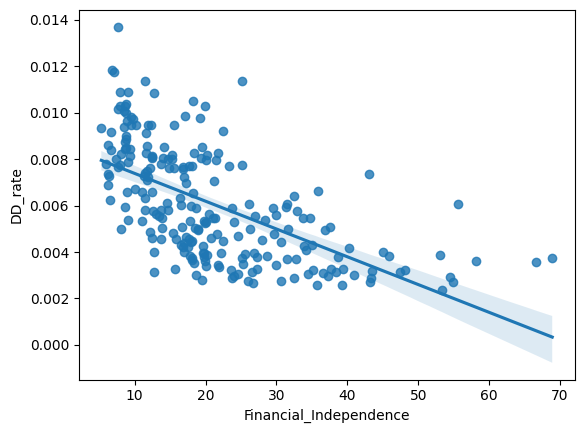

In [39]:
#Draw a graph (X=Financial_Independence Y=DD_rate) with seaborn
sns.regplot(x='Financial_Independence', y='DD_rate', data=data)
plt.show()

## 4. Linear regression (X=Financial_Independence Y=DD_ASD_rate) with statsmodels.formula.api of statsmodels

In [40]:
DD_ASD_rate_ols_smf = smf.ols(formula='DD_ASD_rate ~ Financial_Independence', data=data)

DD_ASD_rate_ols_smf_results = DD_ASD_rate_ols_smf.fit()
DD_ASD_rate_ols_smf_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            DD_ASD_rate   R-squared:                       0.373
Model:                            OLS   Adj. R-squared:                  0.370
Method:                 Least Squares   F-statistic:                     133.6
Date:                Sun, 23 Apr 2023   Prob (F-statistic):           1.44e-24
Time:                        06:04:19   Log-Likelihood:                 372.19
No. Observations:                 227   AIC:                            -740.4
Df Residuals:                     225   BIC:                            -733.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0.0358      0.006      5.719      0.000       0.023       0.048
Financial_Independence     0.0030      0.000     11.560      0.000       0.002       0.003
==============================================================================
Omnibus:                       34.191   Durbin-Watson:                   0.953
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               53.355
Skew:                           0.859   Prob(JB):                     2.59e-12
Kurtosis:                       4.641   Cond. No.                         48.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

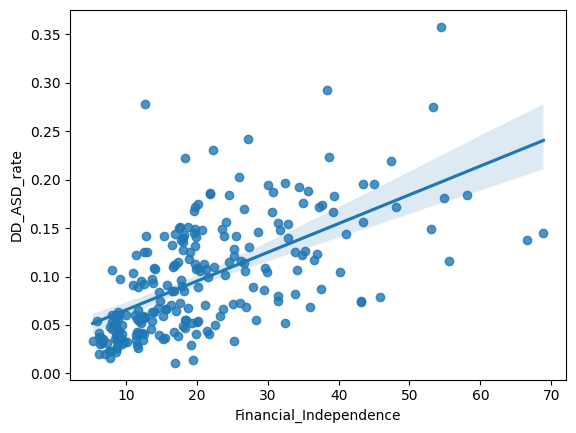

In [41]:
#Draw a graph (X=Financial_Independence Y=DD_ASD_rate) with seaborn
sns.regplot(x='Financial_Independence', y='DD_ASD_rate', data=data)
plt.show()